In [1]:
from __future__ import print_function
import argparse
import random
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import numpy as np
from warpctc_pytorch import CTCLoss
import os,inspect
import sys  
stdout = sys.stdout
reload(sys)  
sys.setdefaultencoding('utf-8')
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import utils
import dataset
import io

import models.crnn as crnn


from model_error import cer, wer


#My workaround was that at the top of the script, I import sys, and store sys.stdout in a separate variable, e.g. stdout.
sys.stdout = stdout
print(sys.getdefaultencoding())
encoding = "utf-8"

utf-8


In [2]:
trainroot = "/deep_data/current_nephi/nephi/data/lmdb_russell/train/"
valroot = "/deep_data/current_nephi/nephi/data/lmdb_russell/val/"
#trainroot = "/home/ubuntu/russell/nephi/data/lmdb_ICFHR_bin/general_data/"
#valroot = "/home/ubuntu/russell/nephi/data/lmdb_ICFHR_bin/specific_data/"
batchSize = 6
test_batch_size = batchSize
nh = 256                  # size of the LSTM hidden state

imgH = 50
imgW = 2000 #imgH * 30
ngpu = 1
beta1 = 0.5
lr = 0.0001
workers = 3
keep_ratio = True
adam = False
adadelta = False
n_test_disp = 100

nc = 1  # 3 if binarized images used

alphabet_file = "/deep_data/current_nephi/nephi/alphabets/JOURNAL_alphabet.txt"
alphabet = ''
if os.path.exists(alphabet_file):
    #alphabet = ''
    with io.open(alphabet_file, 'r', encoding=encoding) as myfile:
        alphabet = myfile.read().split()
        alphabet.append(u' ')
        alphabet = ''.join(alphabet)

In [3]:
manualSeed = random.randint(1, 10000)  # fix seed
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  3149


In [4]:
cudnn.benchmark = True
cuda= True


train_dataset = dataset.lmdbDataset(root=trainroot, binarize = False, test=False)
assert train_dataset

test_dataset = dataset.lmdbDataset(root=valroot, binarize=False, test=False)
assert test_dataset

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchSize, shuffle=True, #sampler=sampler,
    num_workers=int(workers),
    collate_fn=dataset.alignCollate(imgH=imgH, imgW=imgW, keep_ratio=keep_ratio))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batchSize, shuffle=True,  #sampler=dataset.randomSequentialSampler(test_dataset, opt.batchSize),
    num_workers=int(workers),
    collate_fn=dataset.alignCollate(imgH=imgH, imgW=imgW, keep_ratio=keep_ratio))


In [5]:
nclass = len(alphabet) + 1


converter = utils.strLabelConverter(alphabet)
criterion = CTCLoss()

# custom weights initialization called on crnn
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [6]:
crnn = crnn.CRNN(imgH, nc, nclass, nh)
crnn.apply(weights_init)

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace)
    (pooling0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace)
    (pooling1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (relu2): ReLU(inplace)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=(1, 1), ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (relu4): ReLU

In [7]:
image = torch.FloatTensor(batchSize, 3, imgH, imgH)
text = torch.IntTensor(batchSize * 5)          # RA: I don't understand why the text has this size
length = torch.IntTensor(batchSize)

if cuda:
    crnn.cuda()
    crnn = torch.nn.DataParallel(crnn, device_ids=range(ngpu))
    image = image.cuda()
    criterion = criterion.cuda()

In [8]:
image = Variable(image)
text = Variable(text)
length = Variable(length)

# loss averager
loss_avg = utils.averager()

# setup optimizer
if adam:
    optimizer = optim.Adam(crnn.parameters(), lr=lr,
                           betas=(beta1, 0.999))
elif adadelta:
    optimizer = optim.Adadelta(crnn.parameters(), lr=lr)
else:
    optimizer = optim.RMSprop(crnn.parameters(), lr=lr)

In [9]:
#https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
def show_images(images, cols = 1, titles = None, ch = "all"):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        #if image.ndim == 2:
        #    plt.gray()
        if ch == "all":
            plt.imshow(image)
        else:
            plt.imshow(image[:,:,ch], cmap="Greys_r")
            #I, H, B = np.dsplit(image)
            #if ch == 0:
            #    plt.imshow(image[:,:,0])
            #elif ch == 1:
            #    plt.imshow(H)
            #else:
            #    plt.imshow(B)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [10]:
def plots_extreme(char_err, w_err, images, preds, gts, fs, n=5, err="char", best=True, median=False, ch="all"):
    # Fixing random state for reproducibility
    np.random.seed(19680801)

    # Ascending sort
    to_sort = None
    if err=="char":
        to_sort = char_err
    elif err == "word":
        to_sort = w_err
    elif err == "both":
        to_sort = [j/2 for j in (char_err + w_err)]
    s_idxs = [i[0] for i in sorted(enumerate(to_sort), key=lambda x:x[1], reverse = False if best else True)]
    s_char_err = [char_err[i] for i in s_idxs]
    s_w_err = [w_err[i] for i in s_idxs]
    s_images = [images[i] for i in s_idxs]
    s_preds = [preds[i] for i in s_idxs]
    s_gts = [gts[i] for i in s_idxs]
    s_fs = [fs[i] for i in s_idxs]
    
    titles = ["File: %s\nPrediction: %-20s\nGround Truth: %-20s" % (f, pred, gt) for f,pred, gt in zip(s_fs, s_preds, s_gts)]
    #for raw_pred, pred, gt in zip(raw_preds, sim_preds, cpu_texts):
        #print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt))

    print("Got through all the sorting in plots_best")
    if median:
       show_images(s_images[len(s_images)/2:len(s_images)/2+n], cols=5, titles=titles[len(s_images)/2:len(s_images)/2+n], ch=ch)
#         save_images(s_images[len(s_images)/2:len(s_images)/2+n], cols=5, titles=titles[len(s_images)/2:len(s_images)/2+n])

    else:
       show_images(s_images[0:n], cols=5, titles=titles[0:n], ch=ch)
#         save_images(s_images[0:n], cols=5, titles=titles[0:n])
    return(1)
    
    
    # Need to give show images all correct order

In [11]:
def to_grayscale(img):
    image_reshape = np.swapaxes(img, 0, 2)
    image_reshape = np.swapaxes(image_reshape, 0, 1)
    image_reshape = np.squeeze(image_reshape)
    return(image_reshape)

def val(net, dataset, criterion, max_iter=500):
    print('Start val')

    for p in crnn.parameters():
        p.requires_grad = False

    net.eval()
    #data_loader = torch.utils.data.DataLoader(
    #    dataset, shuffle=True, batch_size=batchSize, num_workers=int(workers))
    val_iter = iter(dataset)

    i = 0
    n_correct = 0
    loss_avg = utils.averager()
    
    image_count = 0
    
    
    
    # Character and word error rate lists
    char_error = []
    w_error = []
    
    # Lists of images, predictions and ground truth to correlate with character and word error rates
    image_list = []
    pred_list = []
    gt_list = []
    f_list = []
    

    max_iter = min(max_iter, len(dataset))
    #max_iter = len(data_loader)
    for i in range(max_iter):
        data = val_iter.next()
        i += 1
        cpu_images, cpu_texts, cpu_files = data
        batch_size = cpu_images.size(0)
        image_count = image_count + batch_size
        utils.loadData(image, cpu_images)
        t, l = converter.encode(cpu_texts)
        utils.loadData(text, t)
        utils.loadData(length, l)

        preds = crnn(image)
        preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
        cost = criterion(preds, text, preds_size, length) / batch_size
        loss_avg.add(cost)
        
        
        # RA: While I am not sure yet, it looks like a greedy decoder and not beam search is being used here
        # Also, a simple character by character accuracy is being used, not an edit distance.
        # Case is ignored in the accuracy, which is not ideal for an actual working system
        
        _, preds = preds.max(2)
        if torch.__version__ < '0.2':
          preds = preds.squeeze(2) # https://github.com/meijieru/crnn.pytorch/issues/31
        preds = preds.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(preds.data, preds_size.data, raw=False)
        for pred, target, img, f in zip(sim_preds, cpu_texts, cpu_images.numpy(), cpu_files):
            if pred == target.lower():
                n_correct += 1
            #print(pred)
            #print("Pred: %s; target: %s" % (pred, target))
            char_error.append(cer(pred, target.lower()))
            w_error.append(wer(pred, target.lower()))
            image_list.append(to_grayscale(img))
            pred_list.append(pred)
            gt_list.append(target)
            f_list.append(f)

    raw_preds = converter.decode(preds.data, preds_size.data, raw=True)[:n_test_disp]
    for raw_pred, pred, gt in zip(raw_preds, sim_preds, cpu_texts):
        print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt))

    accuracy = n_correct / float(max_iter * batchSize)
    print('Test loss: %f, accuracy: %f' % (loss_avg.val(), accuracy))
    
    char_arr =np.array(char_error)
    w_arr = np.array(w_error)
    #numpy.std(arr, ddof=1)
    #numpy.mean(arr, axis=0)
    #print("All character error rates:")
    #print(char_error)
    #print("All word error rates")
    #print(w_error)
    print("Character error rate mean: %4.4f; Character error rate sd: %4.4f" % (np.mean(char_arr), np.std(char_arr, ddof=1)))
    print("Word error rate mean: %4.4f; Word error rate sd: %4.4f" % (np.mean(w_arr), np.std(w_arr, ddof=1)))
    print("Total number of images in validation set: %8d" % image_count)
    return (char_error, w_error, image_list, pred_list, gt_list, f_list)

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [13]:
best_model = "/home/remi10001/deep_data/experiments/JOURNAL_19May_third_attempt/ctc/netCRNN_4_483.pth"
#best_model =  "/home/ubuntu/russell/nephi/experiments/expr_ICFHR_17Apr_binarization_augmentation/netCRNN_6_1988.pth"
# we'll see how we do

pre_trained_model = best_model
print('loading pretrained model from %s' % pre_trained_model)
crnn.load_state_dict(torch.load(pre_trained_model))

loading pretrained model from /home/remi10001/deep_data/experiments/JOURNAL_19May_third_attempt/ctc/netCRNN_4_483.pth


In [14]:
data = iter(test_loader).next()
cpu_images, cpu_texts, cpu_files = data

### It seems most of the problem is me not reading in the images well.

(111, 2152, 3)


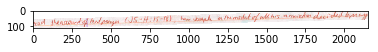

In [94]:
import cv2
from PIL import Image
a = cv2.imread("/deep_data/current_nephi/nephi/data/journal_val_images/My Mission Journal_2011-110_r1l24.jpg")
plt.imshow(Image.fromarray(a), cmap="Greys_r")
print(a.shape)

In [93]:
2000/ 96

20

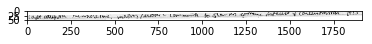

In [15]:
 plt.imshow(to_grayscale(cpu_images.numpy()[3]), cmap="Greys_r")


In [34]:
cv2.imshow(to_grayscale(cpu_images.numpy()[3]))

TypeError: Required argument 'mat' (pos 2) not found

In [32]:
import cv2
cv2.imshow(cpu_images[0])

TypeError: Required argument 'mat' (pos 2) not found

In [17]:
# Validation set pictures
char_error, w_error, all_images, all_preds, all_gts, f_list = val(crnn, test_loader, criterion)

Start val
----------------------------------------------------c----o----m--------pp---a---------i--o--n----s---h----i--s------ -s---t---r----a----yy-------  t--hh----i--sss----  m-------oo--r----m--------ii--n------g-----..-----------  D-----e---s--pp--ii--t-ee---------  -o-----u--------- -s---u---------c---e---s---ss---------- -a-----t-----  t--hh----e-----w------i--ss-----t----t---,------------- -I------  w---------aa---s-------- ---d---ii-ss----tt-rr--a------c---t---e------e---l------------------------------------------------------ => compaionshis stray this morming. Despite ou sucess at thewistt, I was distracteel, gt: companionship study this morning. Despite our success at the visit, I was distracted
-----------------------------------------------------------------------------------------------u----n--ee-------- -2----3--,-----  2----0---1--1---,---  s--u--u-----t--- -t--w----o---- ---d---a---y-----s--- a----y---o---.----- -W------h----a----t--  aa--- t--imm---ee---ll-y--- cc-a--

### It is clear that I am having problems with loading the pictures into an lmdb database. Perhaps the line segmentation is way off. But it clearly isn't loading any pictures right now.

- The problem was with my plot function. The results are beautiful now. If the algorithm can see my text, it does pretty well with high enough resolution. Some of the bottom and top of the image are cut off; I can easily change this in a new lmdb database
- In the worst performing 5 examples I see several issues, some images are clipped on the top and bottom (segmentation bounding box error that can be remedied), some images are smaller size and/or at a angle (slight rotation), one egregious example shows my system has not learned capital print, an easier recognition, but I don't have enough capital letters in my training data.

- I think the following could really improve performance:
    - Increasing the size of my bounding boxes along the vertical dimension, especially if I could do some processing of the pixels to make sure the words are there (or use Transkribus' automatic mask function somehow)
    - Adding noise in terms of size, rotation, grid distortion, maybe shearing. Profile normalization could probably help a lot.
    - Transfer learning would probably help with capital letters. I may have to do a union of the vocabularies for transfer learning, but I don't think it should be so bad.
    - I may want to look at the training images too, but the validation are probably telling me all I need to know.
    - I honestly don't think binarization would really help. It may help learn faster, but background noise doesn't seem to me to be a problem
    
- I will start with improving the segmentation

- ON 2 June 2018 I have the capabiltiy to extend the segmentation box by a defined number of pixels. I am now going to test learning simply with this change. Then I'll add on data augmentation, probably everything at the same time.

In [23]:
all_images[0].shape

(50, 1621)

In [28]:
plt.gray(all_images[0])

TypeError: gray() takes no arguments (1 given)

In [25]:
all_images[0].ndim

2

Got through all the sorting in plots_best


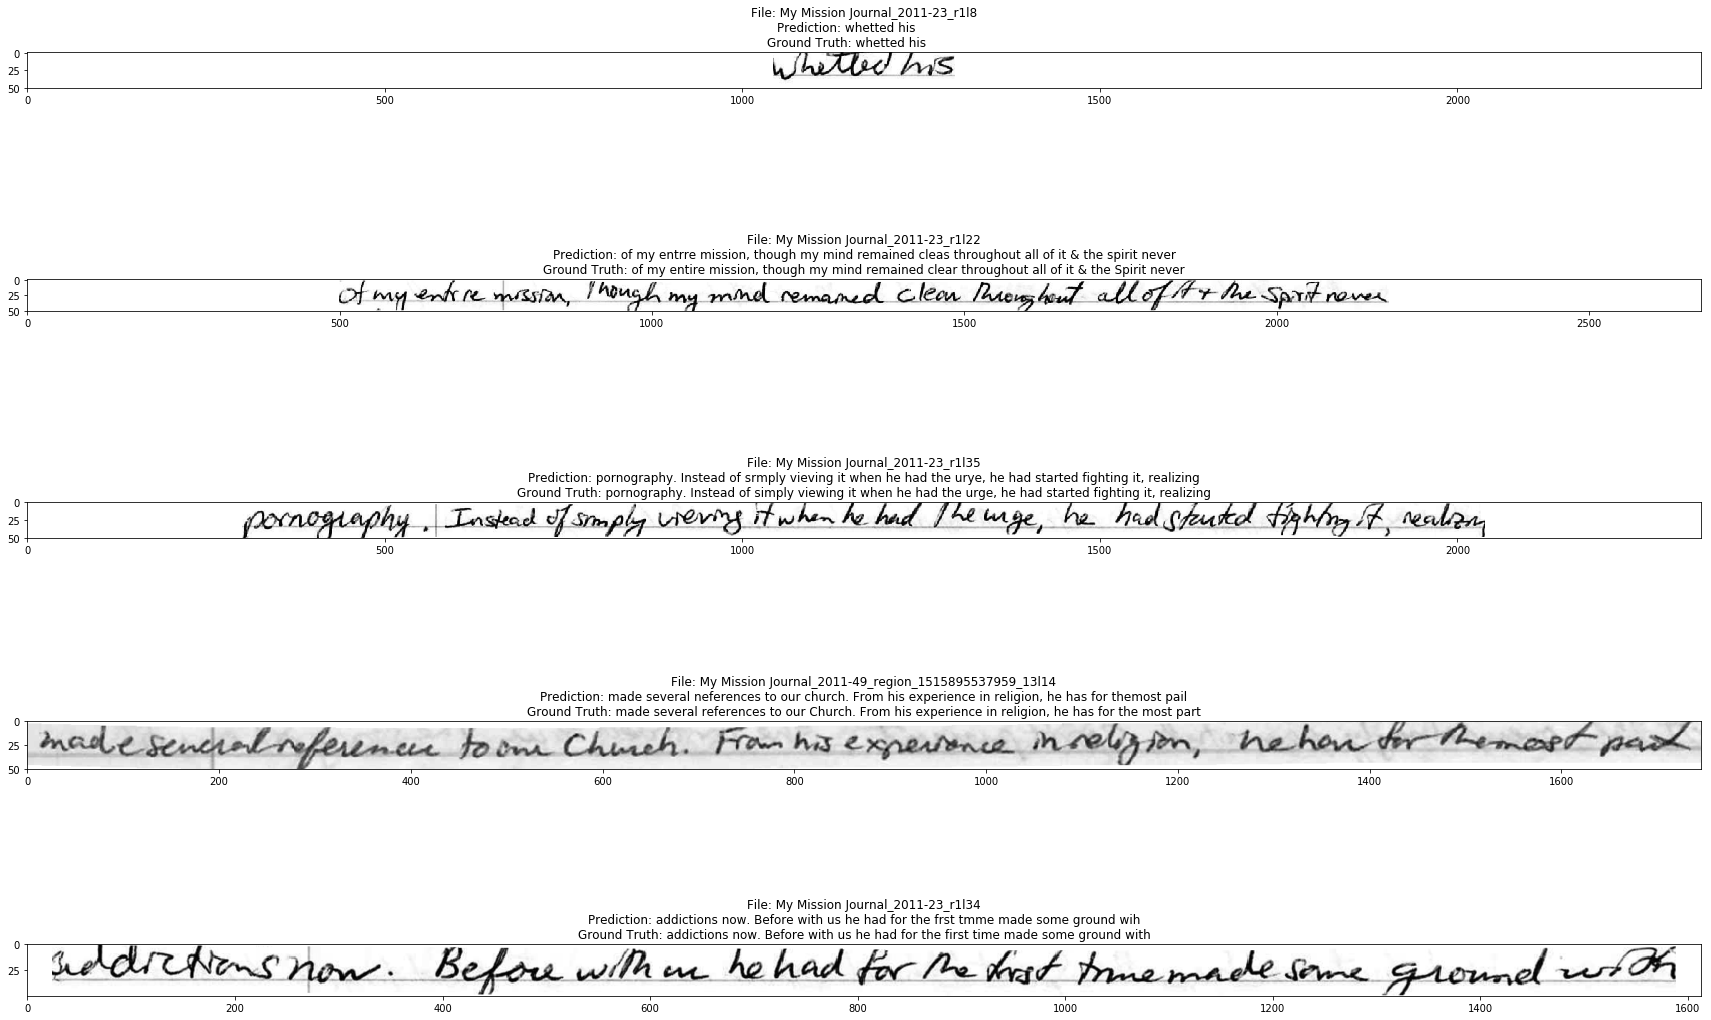

1

In [30]:
# Plot 5 of the best pictures by character error rate
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, f_list, n=5, err="char", best=True, median=False) 

### Interesting, some of these validation pictures seem to have misattributed ground truth. I would like to look at the files to make sure, but I am pretty sure they are erroneous. I can't do anything about that

# Also, from looking at these images, I think some sort of profile normalization could really help. They are different scales, and I don't think my stretching is really helping. Also deslanting or shearing randomly could help. And any other augmenttion Puigcerver did. I can estimate profile normalization based on each text. Maybe test side augmentation too.

Yes, with the image titles, I have confirmed that the ground truth is incorrect for some images. I could tell scriptnet, but I don't think I will. For that picture of un ladro, line 335 is swapped with line 334 in the text. It happens a good amount, at least 3 examples close to each other for the italian data.

Got through all the sorting in plots_best


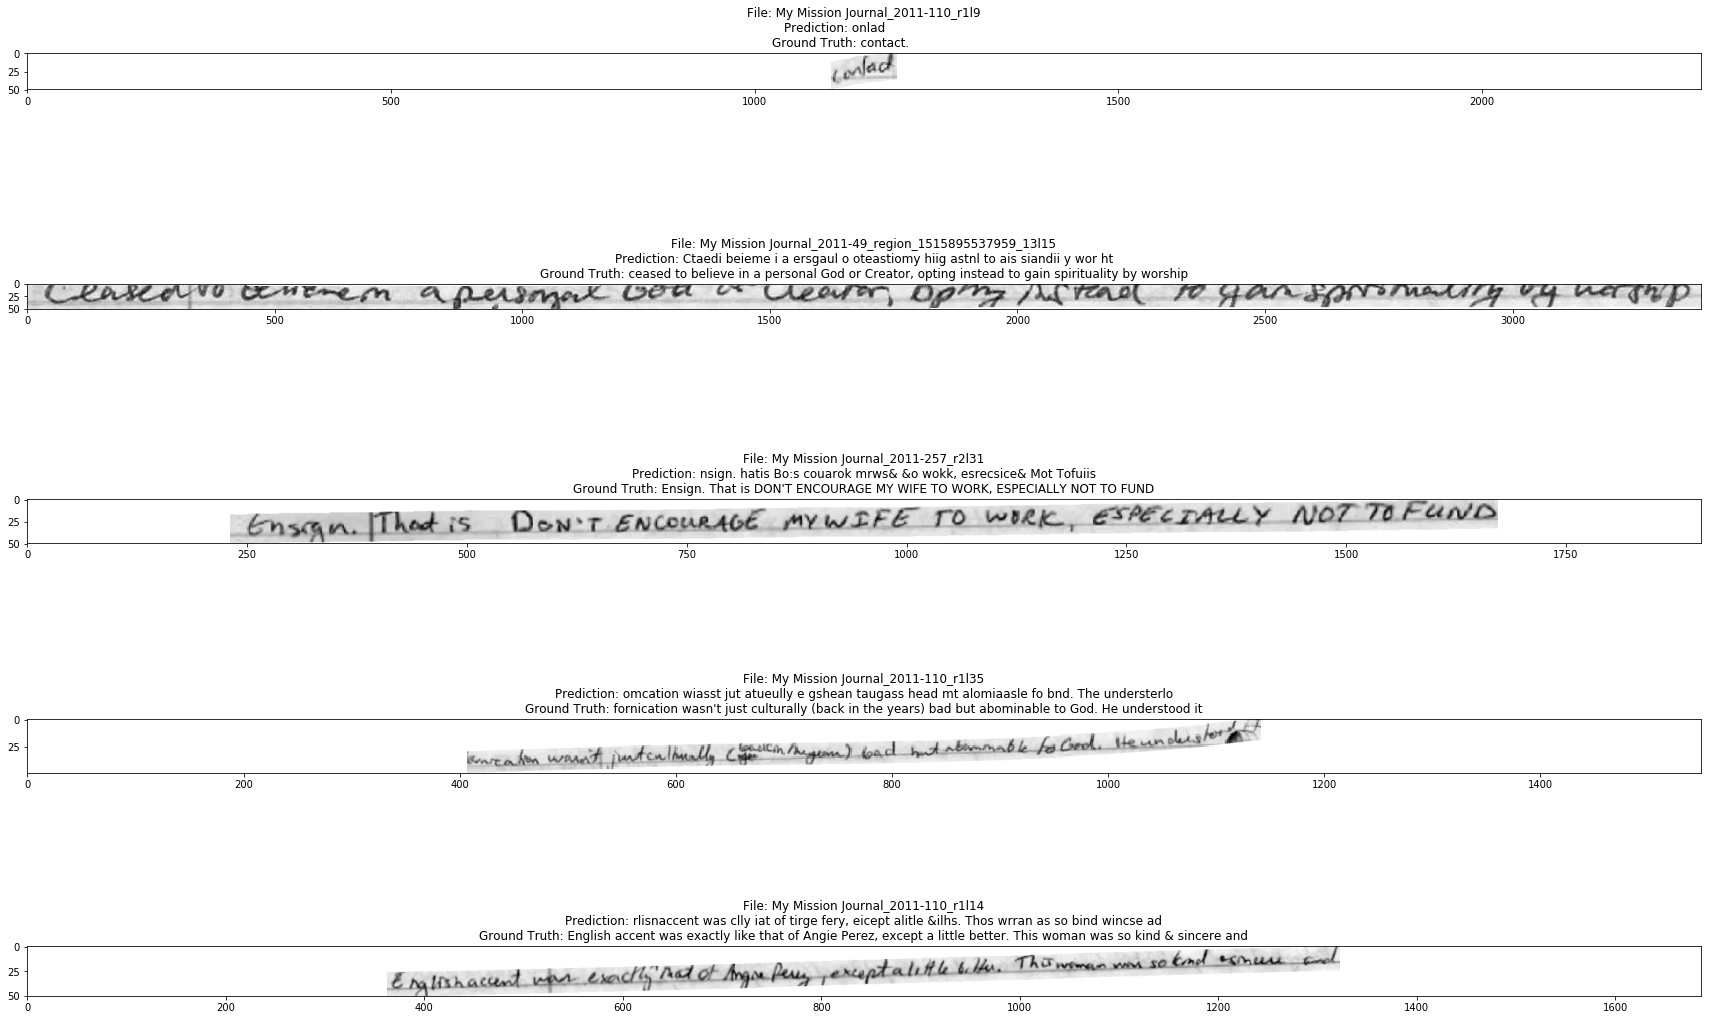

1

In [32]:
# # Plot 5 of the worst pictures
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, f_list, n=5, err="char", best=False, median=False)

Got through all the sorting in plots_best


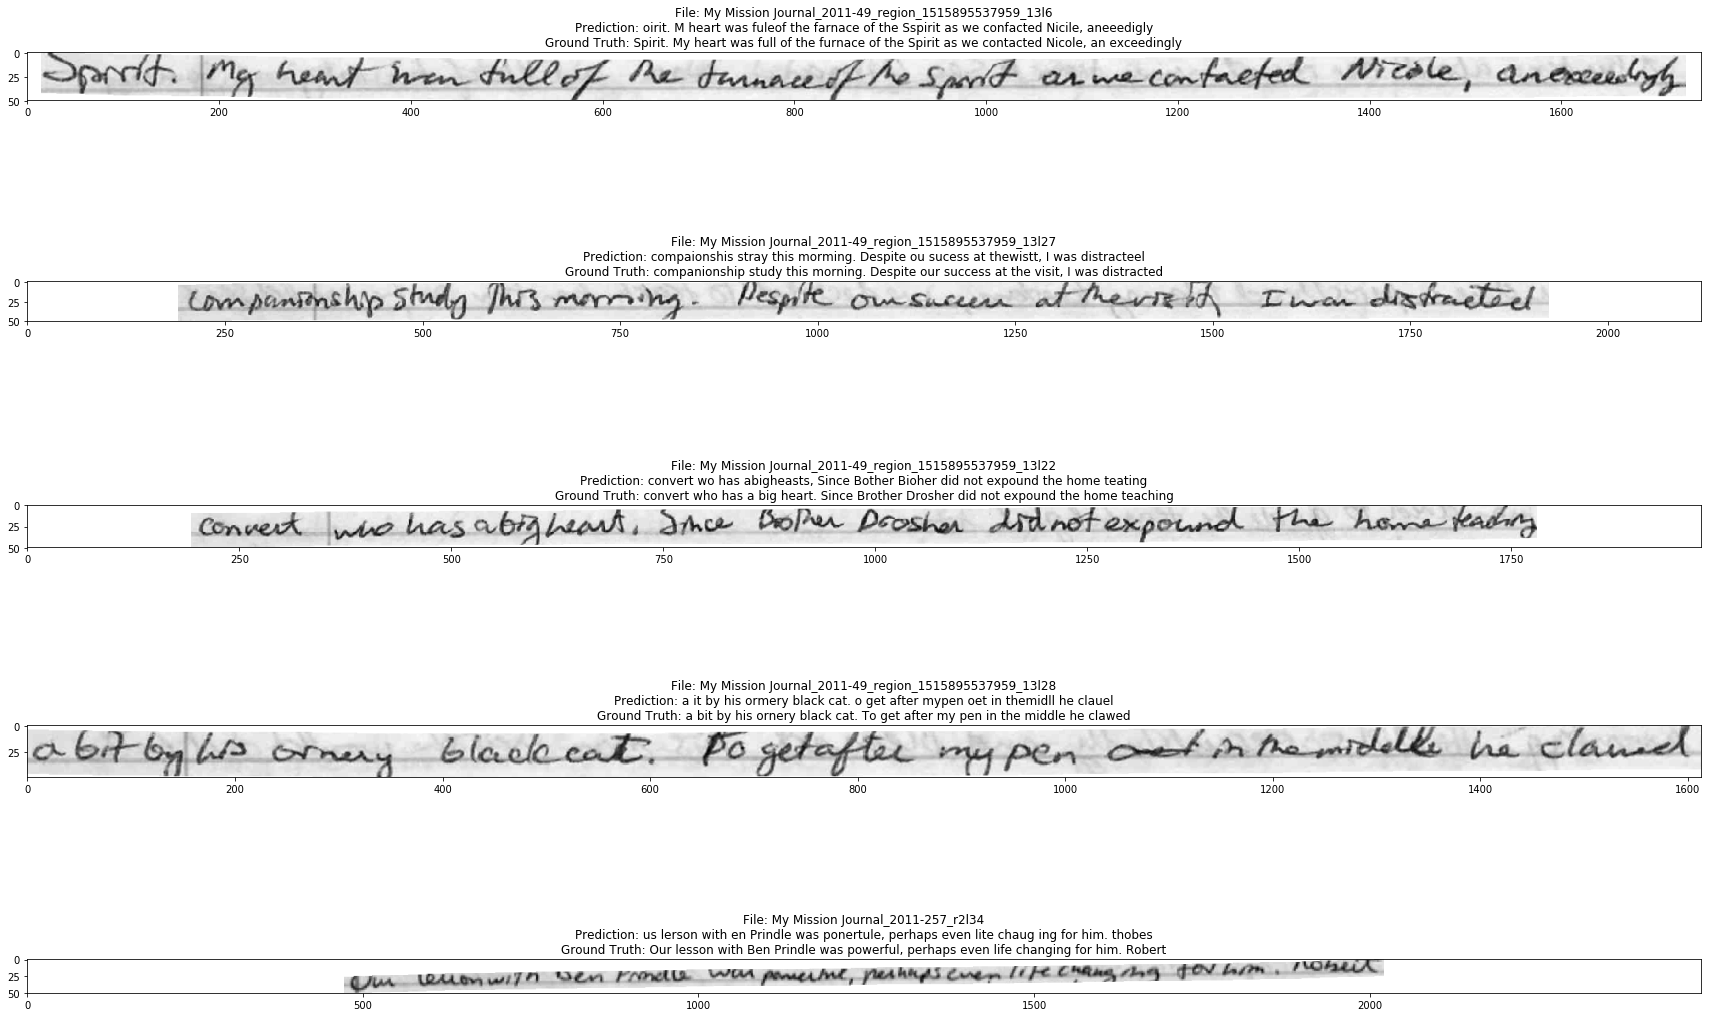

1

In [34]:
# # Plot 5 pictures around the median performance
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, f_list, n=5, err="char", best=True, median=True) 

# 11 April 2018 Notes on Visual Performance when trained on binarized images

### For both the training and test set, the best and median performance is perfect or near perfect for CER. The worse performances seem to be from wildly different scales or poor segmentation. I would like to add a percentile visualization to this. 

### The error rate I am getting on a subset of the data (~1000 lines for both test and training) is different from the error rate the model is outputting during training. I wonder if images are resampled truly each time as batches are formed. I wonder if batches are dynamically made. I probably need to dig deeper into this. I think this is a reason the model isn't being as robust at different size scales.
- A correlary to this is maybe we are not training long enough, despite what the loss and CER/WER say on training

### On some of the worst performing images in the training set, I notice the binarization do a lot worse than the original image in giving signal, especially howe. But in the validation set the worst 5 images were from segmentation but one image looked perfect, so I don't know why it is not performing well. Looking at histograms of the error rates could help me.

In [15]:
# Training set pictures
char_error_t, w_error_t, all_images_t, all_preds_t, all_gts_t, all_files_t = val(crnn, train_loader, criterion)

Start val
-------------h---ee--r----  -g--r---a----n------d--aa---u---g---h----t--ee-ss-------  -t-h--r---o---u---g------s---   t-h----a-----tt-  c---o--uu---p------l---e---------  w--------h---o---  ----dd---i-ee-----d----- -a----t--- -a----g---ee----l-----7------f-r--o---m------- -a------  -c--oo--n------d---ii-t--i--o-nn----  -t--h---a---t-------------- => her grandaughtes througs that couple who died at agel7from a condition that, gt: her granddaughters through that couple who died at age 14 from a condition that
--mm-----a----d--e----  -h---ee--r--- -s---k-----iinn-----  -b---l--ii--s----t--ee--rr-----  w------iii--t--hh--- -o--n----l--y------  aa-----ss---l--i-gg---hh-----t----- -t---o----u-----cc---hh---------..----- TT---h----u--s---- -s---h---ee--  -l-ii-v--e-----d--  -b----a----n--------d- -a-----g---ee------d----  u----pp----  -m------o---s----t--- => made her skin blister with only aslight touch. Thus she lived band aged up most, gt: made her skin blister with only a slight

Got through all the sorting in plots_best


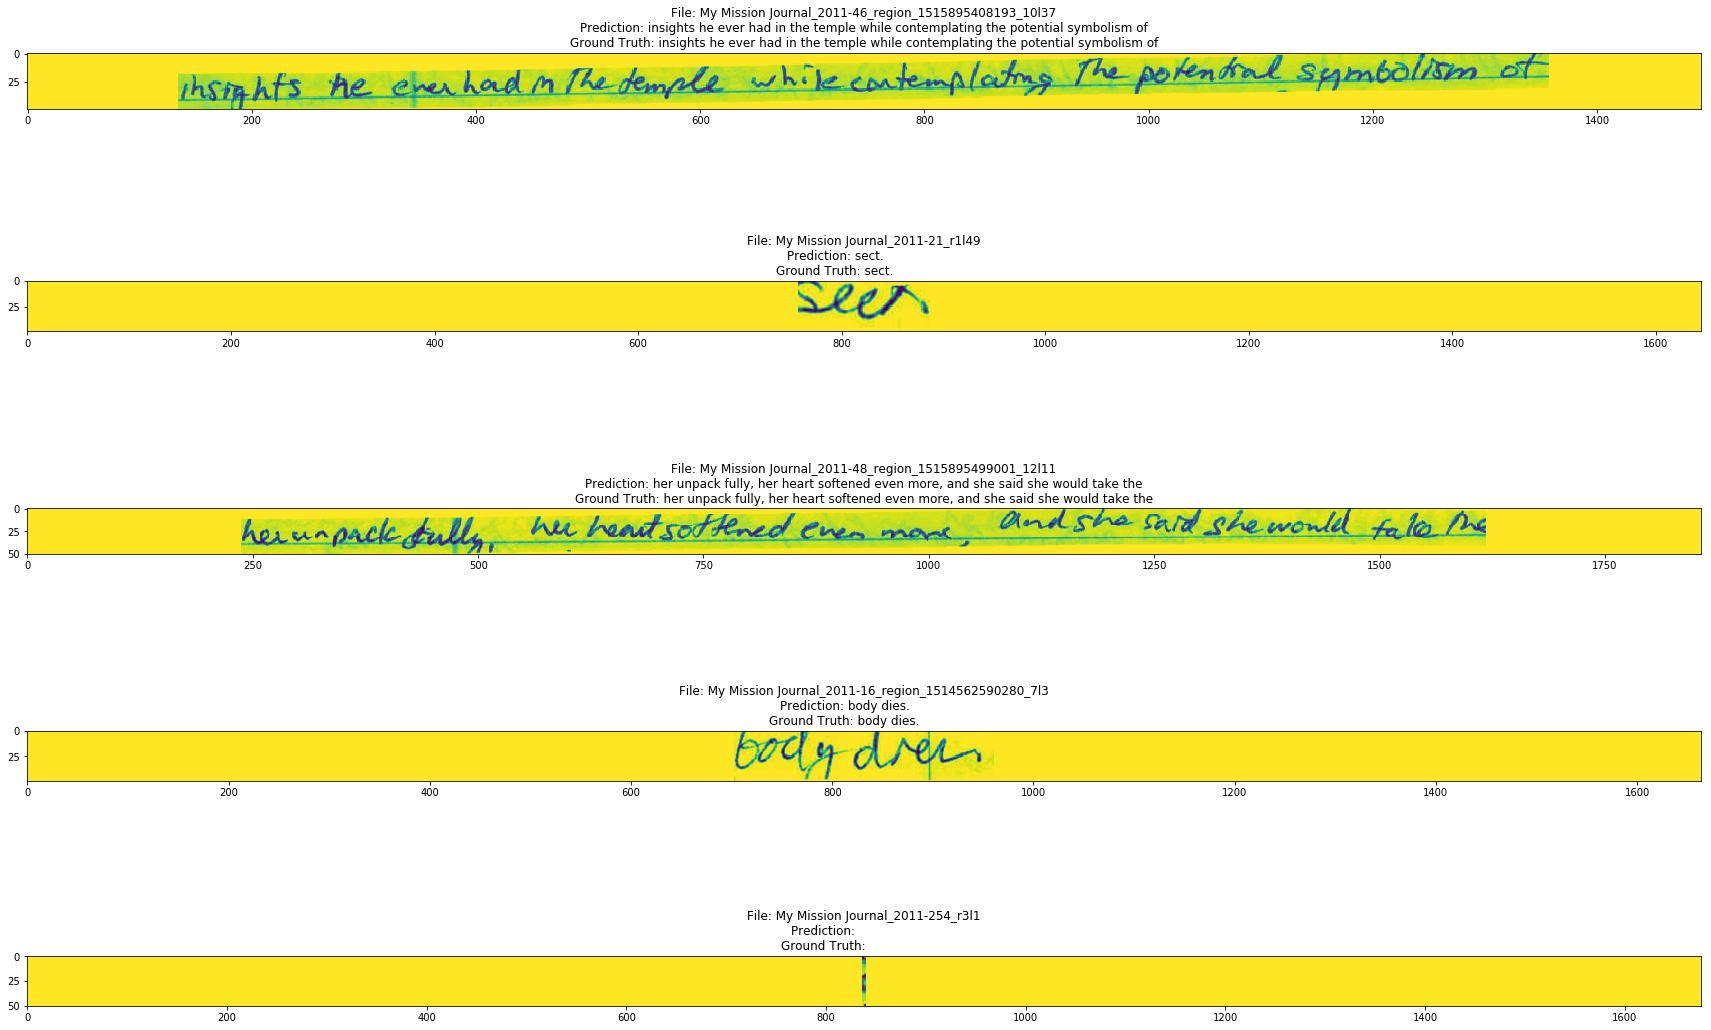

1

In [17]:
# Plot 5 of the best pictures by character error rate
plots_extreme(char_error_t, w_error_t, all_images_t, all_preds_t, all_gts_t, all_files_t, n=5, err="char", best=True, median=False) 

Got through all the sorting in plots_best


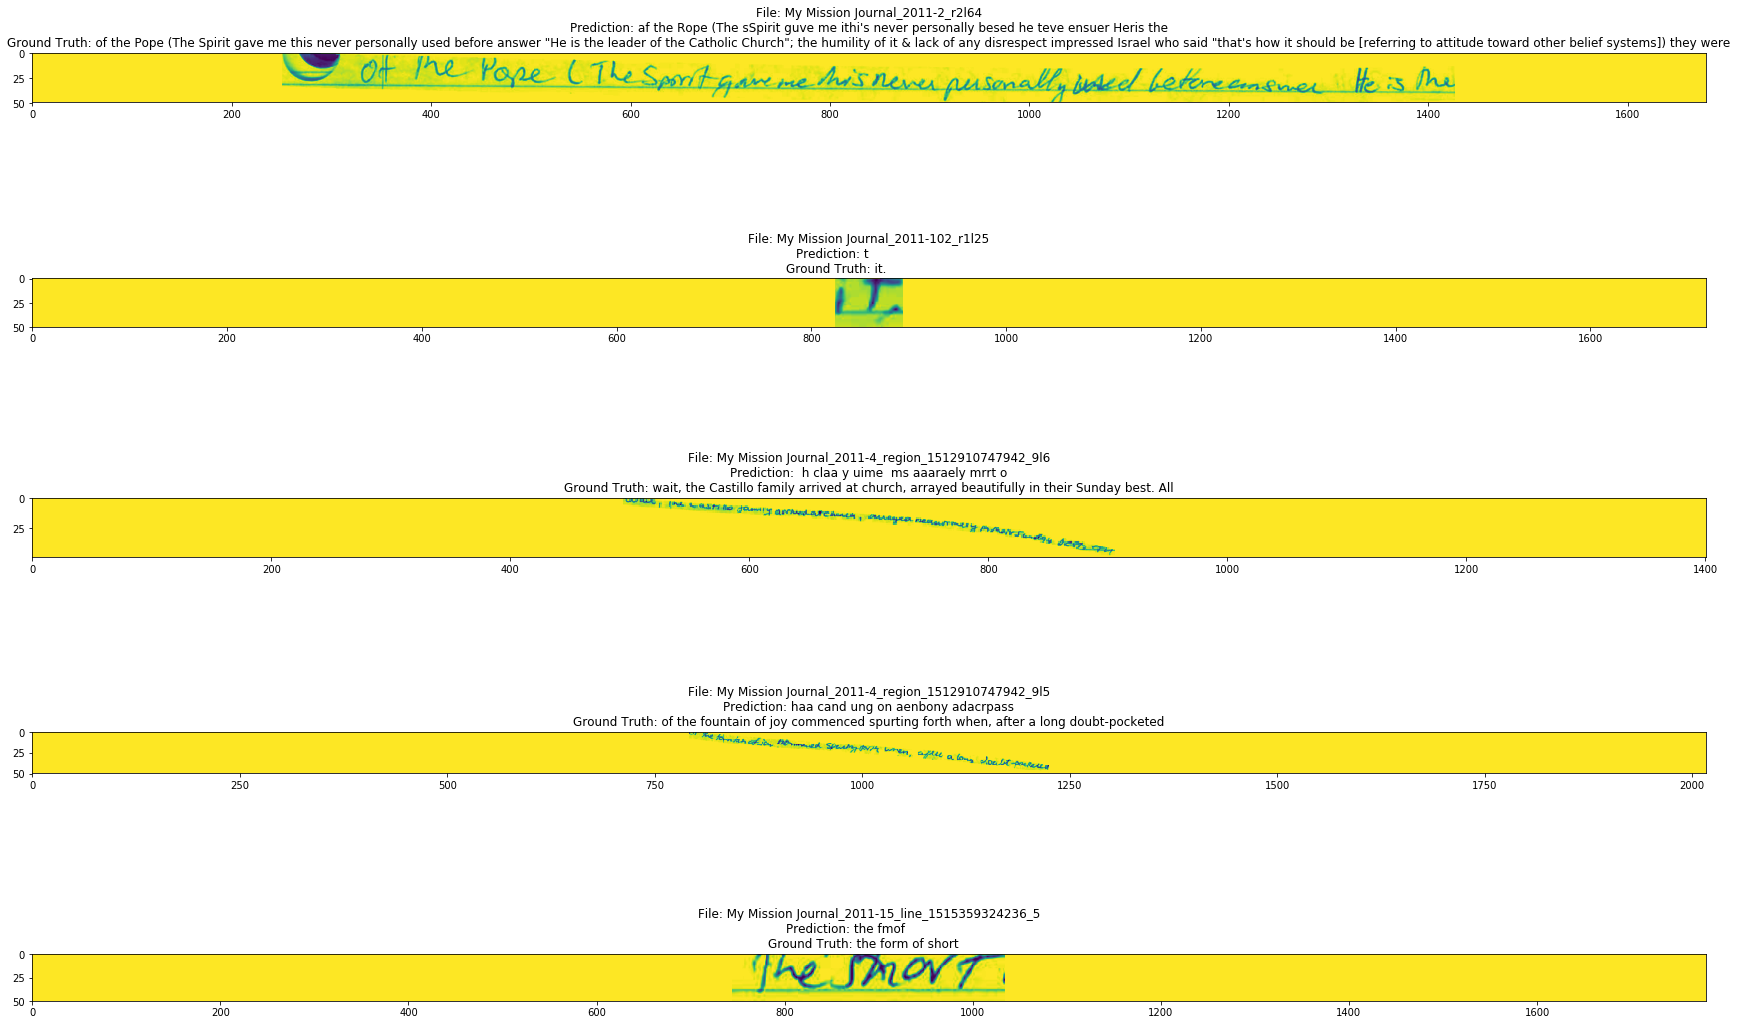

1

In [18]:
# Plot 5 of the worst pictures
plots_extreme(char_error_t, w_error_t, all_images_t, all_preds_t, all_gts_t, all_files_t, n=5, err="char", best=False, median=False)

Got through all the sorting in plots_best


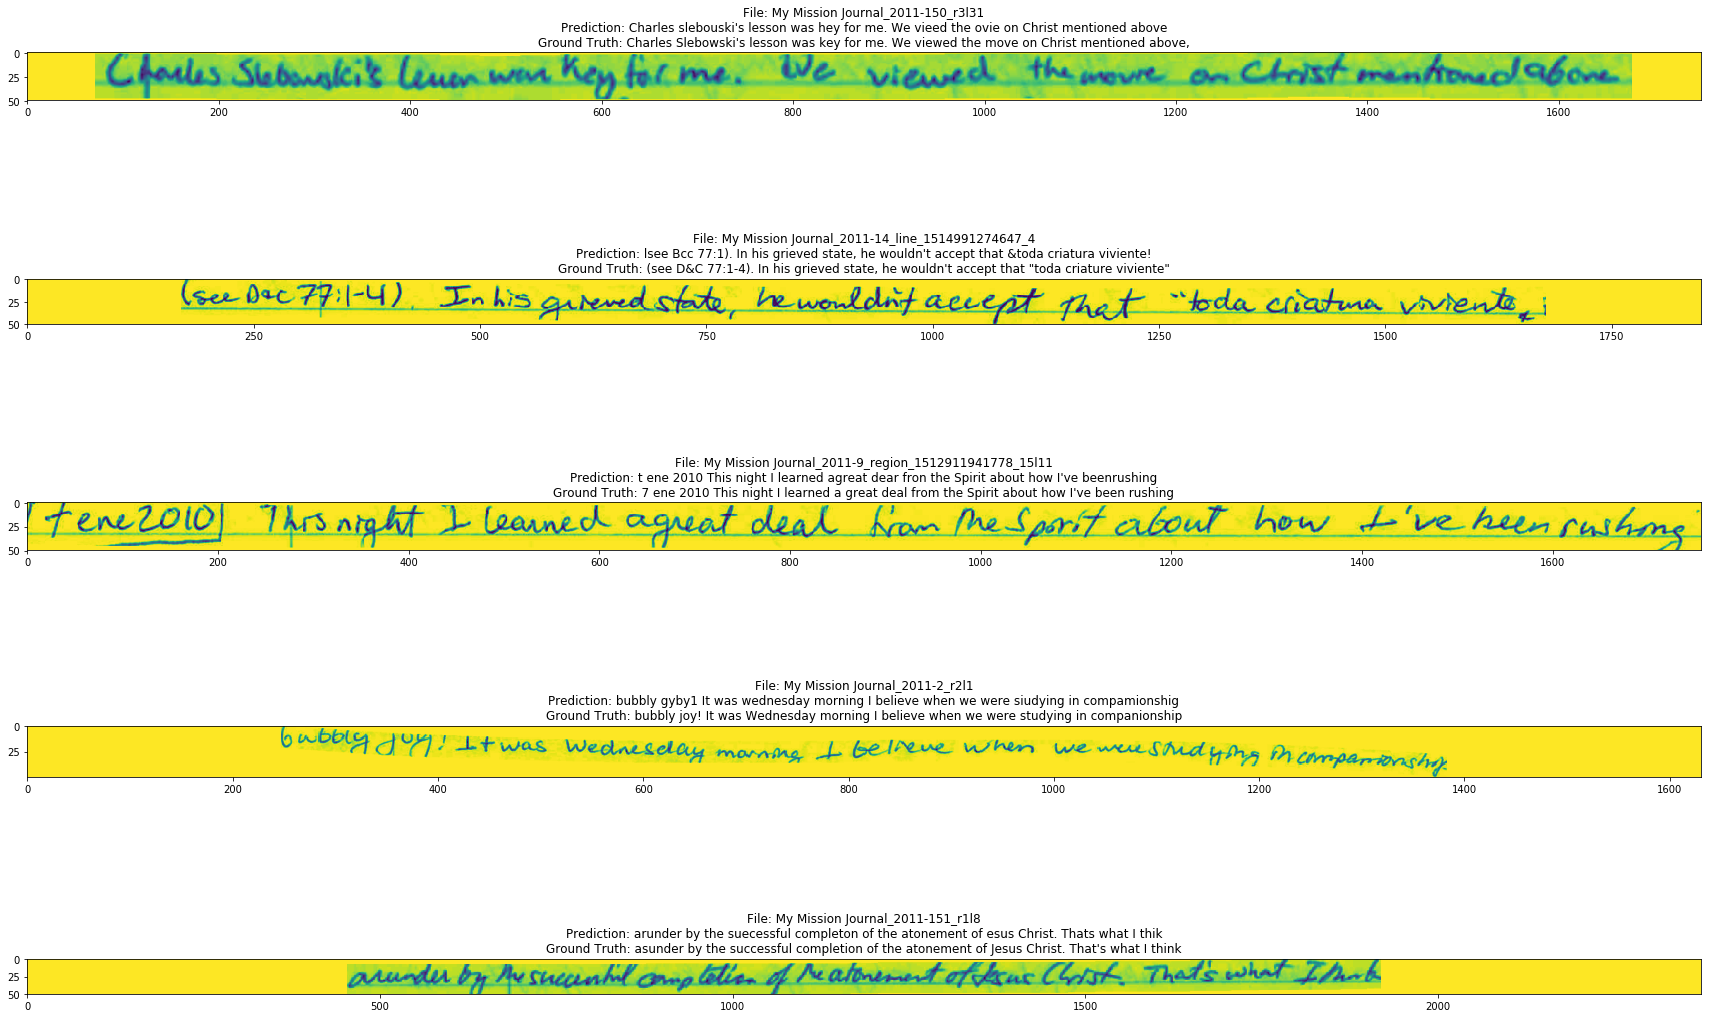

1

In [19]:
# Plot 5 pictures around the median performance
plots_extreme(char_error_t, w_error_t, all_images_t, all_preds_t, all_gts_t, all_files_t, n=5, err="char", best=True, median=True)

In [ ]:
# 800 is an expected overfit model
expect_overfit = "/home/ubuntu/russell/nephi/expr_test_keepaspect_3000/netCRNN_800_131.pth"
# 780 is expected to not overfit as much
expect_great = "/home/ubuntu/russell/nephi/expr_test_keepaspect_3000/netCRNN_780_131.pth"

very_overfit = "/home/ubuntu/russell/nephi/expr_test_keepaspect_3000/netCRNN_850_131.pth"
# we'll see how we do

pre_trained_model = very_overfit
print('loading pretrained model from %s' % pre_trained_model)
crnn.load_state_dict(torch.load(pre_trained_model))

In [ ]:
# Training set pictures
char_error, w_error, all_images, all_preds, all_gts = val(crnn, train_loader, criterion)

# Plot 5 of the best pictures by character error rate
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=False) 

# Plot 5 of the worst pictures
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=False, median=False)

# Plot 5 pictures around the median performance
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=True)

In [ ]:
resized_model = "/home/ubuntu/russell/nephi/expr_test_64h/netCRNN_260_262.pth"
pre_trained_model = resized_model
print('loading pretrained model from %s' % pre_trained_model)
crnn.load_state_dict(torch.load(pre_trained_model))

In [ ]:
# Validation set pictures
char_error, w_error, all_images, all_preds, all_gts = val(crnn, test_loader, criterion)

# Plot 5 of the best pictures by character error rate
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=False) 

# # Plot 5 of the worst pictures
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=False, median=False)

# # Plot 5 pictures around the median performance
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=True) 

In [ ]:
# Training set pictures
char_error, w_error, all_images, all_preds, all_gts = val(crnn, train_loader, criterion)

# Plot 5 of the best pictures by character error rate
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=False) 

# Plot 5 of the worst pictures
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=False, median=False)

# Plot 5 pictures around the median performance
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=True)